In [160]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.autograd import Variable
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
import csv
# Constant
IMG_WIDTH = 128
IMG_HEIGHT = 128
CROP_IMG_WIDTH = 64
CROP_IMG_HEIGHT = 64
class Preprocess():
    def readFile(self,is_crop):
        # read train.csv
        fp = open("train.csv","r",newline='')
        data = pd.read_csv(fp)
        self.train_img_fn = np.array(data["file_name"]) # fn: file name
        labels = np.array(data["category"])
        self.train_label = torch.zeros(len(labels),dtype = torch.long)
        for i in range(len(labels)):
            self.train_label[i] = labels[i]
        self.train_img_info = data.values.tolist()
        # read test.csv
        fp = open("test.csv","r",newline='')
        data = pd.read_csv(fp)
        self.test_img_fn = np.array(data["file_name"]) # fn: file name
        labels = np.array(data["category"])
        self.test_label = torch.zeros(len(labels),dtype = torch.long)
        for i in range(len(labels)):
            self.test_label[i]= labels[i]
        self.test_img_info = data.values.tolist()
        # read train images
        self.train_img = []
        for fi in self.train_img_info:
            im = Image.open("images\\"+fi[0]).convert('RGB')
            if(is_crop == False):
                width = IMG_WIDTH
                ratio = float(width)/im.size[0]
                height = int(im.size[1]*ratio)
                im = im.resize( (width, height), Image.BILINEAR )
                new_im = Image.new(im.mode,(IMG_WIDTH,IMG_HEIGHT),(0,0,0))
                new_im.paste(im,((IMG_WIDTH-im.size[0])//2,(IMG_HEIGHT-im.size[1])//2))
                #new_im = im.resize( (IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR )
                self.train_img.append(np.array(new_im))
            else:
                im = im.crop((fi[3],fi[4],fi[5],fi[6]))
                width = CROP_IMG_WIDTH
                ratio = float(width)/im.size[0]
                height = int(im.size[1]*ratio)
                im = im.resize( (width, height), Image.BILINEAR )
                new_im = Image.new(im.mode,(CROP_IMG_WIDTH,CROP_IMG_HEIGHT),(0,0,0))
                new_im.paste(im,((CROP_IMG_WIDTH-im.size[0])//2,(CROP_IMG_HEIGHT-im.size[1])//2))
                #new_im = im.resize( (IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR )
                self.train_img.append(np.array(new_im))
        self.train_img = np.array(self.train_img)
        self.train_img = self.train_img/255.0
        self.train_img = (self.train_img-np.mean(self.train_img)) / np.std(self.train_img)
        self.train_img = torch.from_numpy(self.train_img).cuda()
        # read test images
        self.test_img = []
        for fi in self.test_img_info:
            im = Image.open("images\\"+fi[0]).convert('RGB')
            if(is_crop == False):
                width = IMG_WIDTH
                ratio = float(width)/im.size[0]
                height = int(im.size[1]*ratio)
                im = im.resize( (width, height), Image.BILINEAR )
                new_im = Image.new(im.mode,(IMG_WIDTH,IMG_HEIGHT),(0,0,0))
                new_im.paste(im,((IMG_WIDTH-im.size[0])//2,(IMG_HEIGHT-im.size[1])//2))
                #new_im = im.resize( (IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR )
                self.test_img.append(np.array(new_im))
            else:
                im = im.crop((fi[3],fi[4],fi[5],fi[6]))
                width = CROP_IMG_WIDTH
                ratio = float(width)/im.size[0]
                height = int(im.size[1]*ratio)
                im = im.resize( (width, height), Image.BILINEAR )
                new_im = Image.new(im.mode,(CROP_IMG_WIDTH,CROP_IMG_HEIGHT),(0,0,0))
                new_im.paste(im,((CROP_IMG_WIDTH-im.size[0])//2,(CROP_IMG_HEIGHT-im.size[1])//2))
                #new_im = im.resize( (IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR )
                self.test_img.append(np.array(new_im))
        self.test_img = np.array(self.test_img)
        self.test_img = self.test_img/255.0
        self.test_img = (self.test_img-np.mean(self.test_img)) / np.std(self.test_img)
        self.test_img = torch.from_numpy(self.test_img).cuda()
    def getImg(self):
        return self.train_img, self.test_img
    def getLabel(self):
        return self.train_label, self.test_label

class CNN1(nn.Module): # 自定義的CNN繼承nn.module
    def __init__(self):
        super(CNN1, self).__init__() # 用父class的__init__()來初始化
        # 開始定義網路中的每一層
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2,inplace=True),
            nn.MaxPool2d(kernel_size=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2,inplace=True),
            nn.MaxPool2d(kernel_size=2),
            )
        self.fully_connect_wo_last = nn.Sequential( # fully-connected without last layer
            # 將CNN的結果fully-connected
            nn.Linear(in_features = 24*32*32, out_features = 2),
        )
        self.last = nn.Linear(in_features = 2, out_features = 7)
    def decoder(self,x):
        x = self.conv1(x) # (BATCH_SIZE,3,128,128) -> (BATCH_SIZE,12,64,64)
        x = self.conv2(x) # (BATCH_SIZE,12,64,64) -> (BATCH_SIZE,24,32,32)
        x = x.view(x.size(0), -1) # flatten x to (BATCH_SIZE,64*16*16)
        x = self.fully_connect_wo_last(x) # (BATCH_SIZE,64*16*16) -> (BATCH_SIZE,2)
        return x
    def forward(self, x):
        x = self.conv1(x) # (BATCH_SIZE,3,128,128) -> (BATCH_SIZE,12,64,64)
        x = self.conv2(x) # (BATCH_SIZE,12,64,64) -> (BATCH_SIZE,24,32,32)
        x = x.view(x.size(0), -1) # flatten x to (BATCH_SIZE,64*16*16)
        x = self.fully_connect_wo_last(x) # (BATCH_SIZE,64*16*16) -> (BATCH_SIZE,2)
        x = self.last(x) # (BATCH_SIZE,2) -> (BATCH_SIZE,7)
        #x = F.softmax(x, dim=1) # (BATCH_SIZE,7) -> (BATCH_SIZE,7)
        return x

## 2-1(a)
- 模型描述
    - Learning rate: 0.001
    - Batch size: 64
    - Epoch number: 100
    - 網路架構 
        - CNN
            - Convolutional layer 1: in_channel=3, out_channel=12, kernel_size=3, stride=1,padding=1
            - Convolutional layer 2: in_channel=12, out_channel=24, kernel_size=3, stride=1,padding=1
            - Linear layer 1: in_features=128\*16\*16, out_features=2
            - Linear layer 2: in_features=2, out_features=7
    - 圖片處理方式
        - 使用Pillow套件
        - 先將圖片的寬度設成128, 接著照原來的長寬比來設定長度
            - 128是取最接近圖片的寬度之2的次方
        - 再來將圖片裁切成128\*128，若有空格就padding 0
        - 最後將值除以255，再做標準化
- 分析討論
    - 測試集的準確率不高
        - 大概只有0.7左右，而training的準確度已經到1.0了
        - 圖片沒有做cropping，所以會把一些不必要的背景一起訓練進去，也會造成模型的缺陷
    - 由loss的圖可以發現，test的loss曲線的震盪很大，有時候甚至最後還一直往上升，推測原因如下
        - 因為訓練集內label數量的分布比較不平均，像是label為0跟1的個數是相對的比較少，可能會導致模型對於預測這些類型的能力比較受限，導致模型產生過度擬合的情況。
        - 還有就是圖片沒有做cropping，所以會把一些不必要的背景一起訓練進去，也會造成模型的缺陷
        - 另外我認為也有可能是batch size太小的原因，導致每個epoch的weight更新比較不準確，但是batch size也不能開得太大，我的GPU的記憶體好像裝不下，算是硬體上的限制。

In [158]:
# Preprocess input files
print("Preprocess starts")
prep = Preprocess()
prep.readFile(is_crop=False)
print("Preprocess ends")

# Get pytorch train and test TensorDataset
train_img, test_img = prep.getImg()
train_label, test_label = prep.getLabel()
train_dataset = torch.utils.data.TensorDataset(train_img,train_label)
test_dataset = torch.utils.data.TensorDataset(test_img,test_label)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Preprocess starts
Preprocess ends


Trainint starts
---ep: 1---
train loss 1.634843
train acc 0.154229
test loss 1.800613
test acc 0.239669
---ep: 2---
train loss 1.396757
train acc 0.307747
test loss 1.629413
test acc 0.314050
---ep: 3---
train loss 1.092197
train acc 0.479744
test loss 1.619439
test acc 0.421488
---ep: 4---
train loss 1.038124
train acc 0.644634
test loss 1.598160
test acc 0.457300
---ep: 5---
train loss 0.936428
train acc 0.670220
test loss 1.451580
test acc 0.471074
---ep: 6---
train loss 0.667257
train acc 0.731343
test loss 1.801255
test acc 0.465565
---ep: 7---
train loss 0.520815
train acc 0.779673
test loss 1.508400
test acc 0.520661
---ep: 8---
train loss 0.532092
train acc 0.804549
test loss 1.838736
test acc 0.531680
---ep: 9---
train loss 0.394121
train acc 0.828714
test loss 1.410207
test acc 0.528926
---ep: 10---
train loss 0.307033
train acc 0.845060
test loss 1.536273
test acc 0.575758
---ep: 11---
train loss 0.342939
train acc 0.882018
test loss 1.409833
test acc 0.614325
---ep: 12---
t

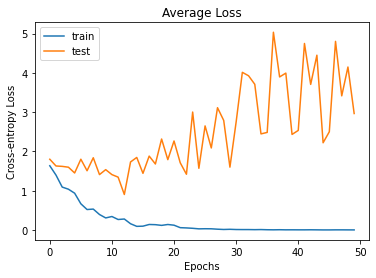

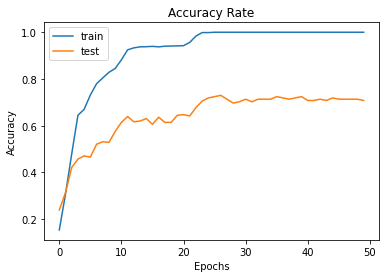

In [161]:
import matplotlib.cm as cm
torch.cuda.set_device(0)
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCH_NUM = 50

# build CNN network
cnn = CNN1()
cnn = cnn.cuda()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss()
input_shape = (-1,3,IMG_WIDTH,IMG_WIDTH)
# train
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
print("Trainint starts")
# latent vector for 2-1(b)
latent_v_list = []
for ep in range(EPOCH_NUM):
    print("---ep: %d---" %(ep+1))
    correct_train = 0
    total_train = 0
    train_loss = 0

    #
    # TRAIN: use each mini-batch training data to train
    #
    for i,(images,labels) in enumerate(train_loader):
        # Reshape
        images = Variable(images.view(input_shape))
        labels = Variable(labels)
        # 清除gradient
        optimizer.zero_grad()
        # Feed forward
        results = cnn(images.float())
        results = results.cpu()
        # Calculate softmax and cross entropy loss
        train_loss = loss_func(results, labels)
        # Backpropagation to get gradient
        train_loss.backward()
        # Update parameters in cnn
        optimizer.step()
        # Get max values' indexes
        # First '1' means we want to find to max value in each column
        # Second '1' means we only want to get the max element's index not the value
        predicted = torch.max(results.data, 1)[1]
        # Accumulate total number
        total_train += len(labels)
        # Accumulate correct number
        correct_train += (predicted == labels).sum().item()
    # Get accuracy
    train_accuracy = correct_train/total_train
    train_accuracy_list.append(train_accuracy)
    # Get loss
    train_loss_list.append(train_loss.data.item())
    print("train loss %f" %train_loss.data)
    print("train acc %f" %train_accuracy)
    #
    # TEST: use each mini-batch test data to test
    #
    correct_test = 0
    total_test = 0
    test_loss = 0
    # without calculating the gradient to accelerate the process
    with torch.no_grad():
        for images, labels in test_loader:
            # Define variable
            images = images.view(input_shape)
            # Feed forward
            results = cnn(images.float())
            results = results.cpu()
            # Calculate softmax and cross entropy loss
            test_loss = loss_func(results, labels)
            # Get max values' indexes
            # First '1' means we want to find to max value in each column
            # Second '1' means we only want to get the max element's index not the value
            predicted = torch.max(results.data, 1)[1]
            # Accumulate total number
            total_test += len(labels)
            # Accumulate correct number
            correct_test += (predicted == labels).sum().item()
        test_accuracy = correct_test / float(total_test)
        test_accuracy_list.append(test_accuracy)
        test_loss_list.append(test_loss.data.item())
        print("test loss %f" %test_loss.data)
        print("test acc %f" %test_accuracy)
    #
    # See latent feature distribution
    #
    if(ep == 2 or ep == 80):
        with torch.no_grad():
            latent_v = cnn.decoder(test_img.view(-1,3,IMG_WIDTH,IMG_WIDTH).float()).detach().cpu().numpy()
        latent_v_list.append(latent_v)
# Plot graph
plt.plot(train_loss_list,label="train")
plt.plot(test_loss_list,label="test")  
plt.title("Average Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy Loss")
plt.legend(loc='best')
plt.show()

plt.plot(train_accuracy_list, label='train')
plt.plot(test_accuracy_list, label='test')
plt.title("Accuracy Rate")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

## 2-1(b)
- 操作方法
    - 訓練時，在指定的epoch時，讀取output layer前的資料，將之存起來，最後在這邊印出來

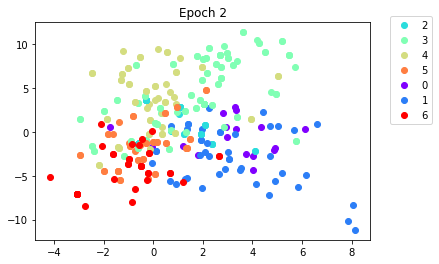

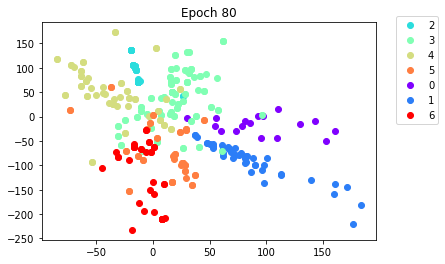

In [107]:
from collections import OrderedDict
train_label, test_label = prep.getLabel()
latent_label = test_label.int().numpy()
# get colors for different category id
colors = cm.rainbow(np.linspace(0, 1, 7))
# plot the graph
for i in range(len(latent_label)):
    plt.plot(latent_v_list[0][i][0],latent_v_list[0][i][1],'o',color=colors[latent_label[i]],label=latent_label[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.2, 1.05))
plt.title("Epoch 2")
plt.show()
# plot the graph
for i in range(len(latent_label)):
    plt.plot(latent_v_list[1][i][0],latent_v_list[1][i][1],'o',color=colors[latent_label[i]],label=latent_label[i])
#plt.legend(bbox_to_anchor=(1.2, 1.05))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.2, 1.05))
plt.title("Epoch 80")
plt.show()

## 2-2(a)
- 模型描述
    - Learning rate: 0.0003
    - Batch size: 256
    - Epoch number: 100
    - 網路架構 
        - CNN
            - Convolutional layer 1: in_channel=3, out_channel=16, kernel_size=3, stride=1,padding=1
            - Convolutional layer 2: in_channel=16, out_channel=32, kernel_size=3, stride=1,padding=1
            - Convolutional layer 3: in_channel=32, out_channel=64, kernel_size=3, stride=1,padding=1
            - Linear layer 1: in_features=128\*8\*8, out_features=2
            - Linear layer 2: in_features=2, out_features=7
    - 圖片處理方式
        - 使用Pillow套件
        - 先將圖片的寬度設成64, 接著照原來的長寬比來設定長度
            - 64是取最接近圖片的寬度之2的次方
        - 再來將圖片裁切成64\*64，若有空格就padding 0
        - 最後將值除以255，再做標準化
- 分析討論
    - 由2-1(a)和2-2(a)的結果可以發現input資料的重要性，當有了裁切範圍之後，把不重要的背景圖案去除就可以更準確的知道目標圖案的樣子，訓練起來的模型準確率也會高上許多，裁切之後測試的準確率高達0.9左右(未裁切前為0.7左右)
    - 由loss的圖可以發現，test的loss曲線的震盪很大，推測原因如下
        - 因為訓練集內label數量的分布比較不平均，像是label為0跟1的個數是相對的比較少，可能會導致模型對於預測這些類型的能力比較受限，導致模型產生過度擬合的情況。
        - 另外我認為也有可能是batch size太小的原因，導致每個epoch的weight更新比較不準確，但是我的顯卡好像記憶體不太夠，不能開太大，算是硬體上的限制。

In [76]:
class CNN2(nn.Module): # 自定義的CNN繼承nn.module
    def __init__(self):
        super(CNN2, self).__init__() # 用父class的__init__()來初始化
        # 開始定義網路中的每一層
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            )
        self.fully_connect_wo_last = nn.Sequential( # fully-connected without last layer
            # 將CNN的結果fully-connected
            nn.Linear(in_features = 64*8*8, out_features = 2)
        )
        self.last = nn.Linear(in_features = 2, out_features = 7)
    def decoder(self,x):
        x = self.conv1(x) # (BATCH_SIZE,3,128,128) -> (BATCH_SIZE,16,64,64)
        x = self.conv2(x) # (BATCH_SIZE,16,64,64) -> (BATCH_SIZE,32,32,32)
        x = self.conv3(x)
        x = x.view(x.size(0), -1) # flatten x to (BATCH_SIZE,64*16*16)
        x = self.fully_connect_wo_last(x) # (BATCH_SIZE,64*16*16) -> (BATCH_SIZE,2)
        return x
    def forward(self, x):
        x = self.conv1(x) # (BATCH_SIZE,3,128,128) -> (BATCH_SIZE,16,64,64)
        x = self.conv2(x) # (BATCH_SIZE,16,64,64) -> (BATCH_SIZE,32,32,32)
        x = self.conv3(x)
        x = x.view(x.size(0), -1) # flatten x to (BATCH_SIZE,64*16*16)
        x = self.fully_connect_wo_last(x) # (BATCH_SIZE,64*16*16) -> (BATCH_SIZE,2)
        x = self.last(x) # (BATCH_SIZE,2) -> (BATCH_SIZE,7)
        #x = F.softmax(x, dim=1) # (BATCH_SIZE,7) -> (BATCH_SIZE,7)
        return x

In [87]:
# Preprocess input files
print("Preprocess starts")
prep = Preprocess()
prep.readFile(is_crop=True)
print("Preprocess ends")
# Get pytorch train and test TensorDataset
train_img, test_img = prep.getImg()
train_label, test_label = prep.getLabel()
train_dataset = torch.utils.data.TensorDataset(train_img,train_label)
test_dataset = torch.utils.data.TensorDataset(test_img,test_label)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Preprocess starts
Preprocess ends


Training starts
---ep: 1---
train loss 2.050483
train acc 0.106610
test loss 1.976340
test acc 0.181818
---ep: 2---
train loss 1.949937
train acc 0.140725
test loss 1.989863
test acc 0.195592
---ep: 3---
train loss 1.881465
train acc 0.180526
test loss 1.899743
test acc 0.234160
---ep: 4---
train loss 1.810697
train acc 0.189055
test loss 1.764185
test acc 0.256198
---ep: 5---
train loss 1.790550
train acc 0.191898
test loss 1.737045
test acc 0.253444
---ep: 6---
train loss 1.605056
train acc 0.200426
test loss 1.706783
test acc 0.261708
---ep: 7---
train loss 1.487265
train acc 0.211798
test loss 1.576199
test acc 0.275482
---ep: 8---
train loss 1.362948
train acc 0.295665
test loss 1.562736
test acc 0.333333
---ep: 9---
train loss 1.279710
train acc 0.348259
test loss 1.524860
test acc 0.374656
---ep: 10---
train loss 1.240514
train acc 0.457001
test loss 1.273468
test acc 0.443526
---ep: 11---
train loss 1.163571
train acc 0.509595
test loss 1.333626
test acc 0.465565
---ep: 12---
t

train loss 0.049872
train acc 0.976546
test loss 0.178577
test acc 0.909091
---ep: 95---
train loss 0.057453
train acc 0.984364
test loss 0.180036
test acc 0.903581
---ep: 96---
train loss 0.072169
train acc 0.978678
test loss 0.227021
test acc 0.903581
---ep: 97---
train loss 0.079843
train acc 0.984364
test loss 0.194667
test acc 0.914601
---ep: 98---
train loss 0.036497
train acc 0.983653
test loss 0.136754
test acc 0.914601
---ep: 99---
train loss 0.061752
train acc 0.981521
test loss 0.291090
test acc 0.898072
---ep: 100---
train loss 0.065277
train acc 0.984364
test loss 0.197818
test acc 0.922865


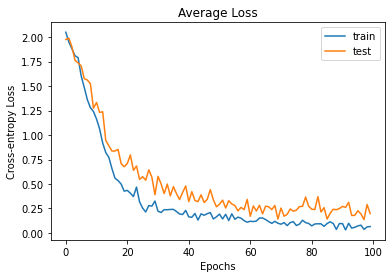

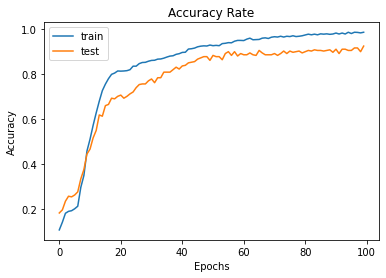

In [88]:
# Hyperparameters
LEARNING_RATE = 0.0003
BATCH_SIZE = 256
EPOCH_NUM = 100

# build CNN network
cnn = CNN2()
cnn = cnn.cuda()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss()
input_shape = (-1,3,CROP_IMG_WIDTH,CROP_IMG_HEIGHT)
# train
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
# latent vector for 2-1(b)
latent_v_list = []
print("Training starts")
for ep in range(EPOCH_NUM):
    print("---ep: %d---" %(ep+1))
    correct_train = 0
    total_train = 0
    train_loss = 0

    #
    # TRAIN: use each mini-batch training data to train
    #
    for i,(images,labels) in enumerate(train_loader):
        # Reshape
        images = Variable(images.view(input_shape))
        labels = Variable(labels)
        # 清除gradient
        optimizer.zero_grad()
        # Feed forward
        results = cnn(images.float())
        results = results.cpu()
        # Calculate softmax and cross entropy loss
        train_loss = loss_func(results, labels)
        # Backpropagation to get gradient
        train_loss.backward()
        # Update parameters in cnn
        optimizer.step()
        # Get max values' indexes
        # First '1' means we want to find to max value in each column
        # Second '1' means we only want to get the max element's index not the value
        predicted = torch.max(results.data, 1)[1]
        # Accumulate total number
        total_train += len(labels)
        # Accumulate correct number
        correct_train += (predicted == labels).sum().item()
    # Get accuracy
    train_accuracy = correct_train/total_train
    train_accuracy_list.append(train_accuracy)
    # Get loss
    train_loss_list.append(train_loss.data.item())
    print("train loss %f" %train_loss.data)
    print("train acc %f" %train_accuracy)
    #
    # TEST: use each mini-batch test data to test
    #
    correct_test = 0
    total_test = 0
    test_loss = 0
    # without calculating the gradient to accelerate the process
    with torch.no_grad():
        for images, labels in test_loader:
            # Define variable
            images = images.view(input_shape)
            # Feed forward
            results = cnn(images.float())
            results = results.cpu()
            # Calculate softmax and cross entropy loss
            test_loss = loss_func(results, labels)
            # Get max values' indexes
            # First '1' means we want to find to max value in each column
            # Second '1' means we only want to get the max element's index not the value
            predicted = torch.max(results.data, 1)[1]
            # Accumulate total number
            total_test += len(labels)
            # Accumulate correct number
            correct_test += (predicted == labels).sum().item()
        test_accuracy = correct_test / float(total_test)
        test_accuracy_list.append(test_accuracy)
        test_loss_list.append(test_loss.data.item())
        print("test loss %f" %test_loss.data)
        print("test acc %f" %test_accuracy)
    #
    # See latent feature distribution
    #
    if(ep == 2 or ep == 90):
        with torch.no_grad():
            latent_v = cnn.decoder(test_img.view(-1,3,64,64).float()).detach().cpu().numpy()
        latent_v_list.append(latent_v)
# Plot graph
plt.plot(train_loss_list,label="train")
plt.plot(test_loss_list,label="test")  
plt.title("Average Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy Loss")
plt.legend(loc='best')
plt.show()

plt.plot(train_accuracy_list, label='train')
plt.plot(test_accuracy_list, label='test')
plt.title("Accuracy Rate")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

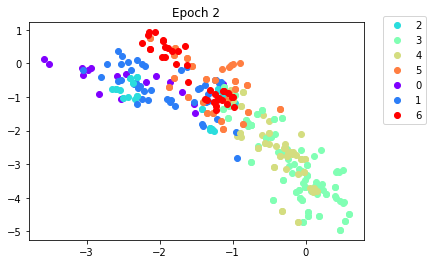

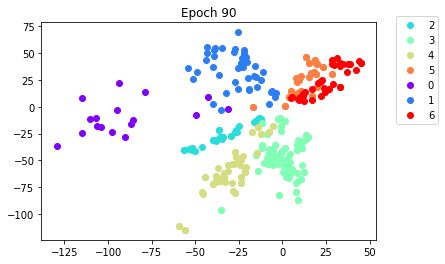

In [85]:
from collections import OrderedDict
train_label, test_label = prep.getLabel()
latent_label = test_label.int().numpy()
# get colors for different category id
colors = cm.rainbow(np.linspace(0, 1, 7))
# plot the graph
for i in range(len(latent_label)):
    plt.plot(latent_v_list[0][i][0],latent_v_list[0][i][1],'o',color=colors[latent_label[i]],label=latent_label[i])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.2, 1.05))
plt.title("Epoch 2")
plt.show()
# plot the graph
for i in range(len(latent_label)):
    plt.plot(latent_v_list[1][i][0],latent_v_list[1][i][1],'o',color=colors[latent_label[i]],label=latent_label[i])
#plt.legend(bbox_to_anchor=(1.2, 1.05))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.2, 1.05))
plt.title("Epoch 90")
plt.show()

## 2-2(b)
- 分析討論
    - 由2-1(a)和2-2(a)的結果可以發現input資料的重要性，當有了裁切範圍之後，把不重要的背景圖案去除就可以更準確的知道目標圖案的樣子
        - 訓練起來的模型準確率高上許多，裁切之後測試的準確率高達0.9左右(未裁切前為0.65左右)
        - test loss之曲線也震盪的比較小了，因為模型更加準確，overfitting的問題也相對降低
        - 另外，latent vector的圖也分得更開了
    - 2-1/2-2有一樣的問題，由loss的圖可以發現，test的loss曲線的震盪蠻大的，推測原因如下
        - 因為訓練集內label數量的分布比較不平均，像是label為0跟1的個數是相對的比較少，可能會導致模型對於預測這些類型的能力比較受限，導致模型產生過度擬合的情況。
        - 另外我認為也有可能是batch size太小的原因，導致每個epoch的weight更新比較不準確，但是我的顯卡好像記憶體不太夠，不能開太大，算是硬體上的限制。